In [61]:
# Import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from fbprophet import Prophet
# Statsmodels widely known for forecasting than Prophet
import statsmodels.api as sm
from scipy import stats

import plotly as py
from plotly import tools
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

from scipy.signal import savgol_filter
# plt.style.available
plt.style.use("seaborn-whitegrid")

# Data Preprocessing

In [28]:
path = ''
df = pd.read_csv(path + 'AMZN_data.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Name
0,2016-02-03,556.000000,521.900024,553.500000,531.070007,10048700,531.070007,AMZN
1,2016-02-04,538.989990,519.219971,525.000000,536.260010,6199100,536.260010,AMZN
2,2016-02-05,529.450012,499.190002,529.280029,502.130005,9708900,502.130005,AMZN
3,2016-02-08,493.500000,475.209991,486.470001,488.100006,9825500,488.100006,AMZN
4,2016-02-09,498.380005,474.000000,478.010010,482.070007,7077900,482.070007,AMZN


In [29]:
df = df.rename(columns={'Name': 'Ticks'})

In [30]:
amzn = df.loc[df['Ticks'] == 'AMZN']
amzn.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Ticks
0,2016-02-03,556.000000,521.900024,553.500000,531.070007,10048700,531.070007,AMZN
1,2016-02-04,538.989990,519.219971,525.000000,536.260010,6199100,536.260010,AMZN
2,2016-02-05,529.450012,499.190002,529.280029,502.130005,9708900,502.130005,AMZN
3,2016-02-08,493.500000,475.209991,486.470001,488.100006,9825500,488.100006,AMZN
4,2016-02-09,498.380005,474.000000,478.010010,482.070007,7077900,482.070007,AMZN


In [31]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 1259
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   High       1260 non-null   float64
 2   Low        1260 non-null   float64
 3   Open       1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Volume     1260 non-null   int64  
 6   Adj Close  1260 non-null   float64
 7   Ticks      1260 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 88.6+ KB


In [34]:
# convert to date-time format
amzn_df = amzn.copy()
# Change to datetime datatype.
amzn_df.loc[:, 'Date'] = pd.to_datetime(amzn.loc[:,'Date'], format="%Y/%m/%d")
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 1259
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   High       1260 non-null   float64       
 2   Low        1260 non-null   float64       
 3   Open       1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Volume     1260 non-null   int64         
 6   Adj Close  1260 non-null   float64       
 7   Ticks      1260 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 88.6+ KB


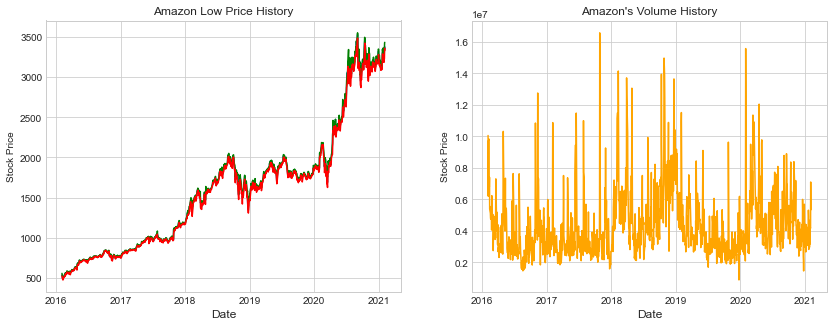

In [36]:
# Simple plotting of Amazon Stock Price
# First Subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(amzn_df["Date"], amzn_df["Close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Amazon Close Price History")

# Second Subplot
ax1.plot(amzn_df["Date"], amzn_df["High"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Amazon High Price History")

# Third Subplot
ax1.plot(amzn_df["Date"], amzn_df["Low"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Amazon Low Price History")

# Fourth Subplot
ax2.plot(amzn_df["Date"], amzn_df["Volume"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Amazon's Volume History")
plt.show()

# Prophet Model
Steps for using Prophet:
- Make sure you replace closing price for y and date for ds.
- Fit that dataframe to Prophet in order to detect future patterns.
- Predict the upper and lower prices of the closing price.


In [44]:
m = Prophet()

# Drop the columns
ph_df = amzn_df.drop(['Open', 'High', 'Low','Volume', 'Ticks', 'Adj Close'], axis=1)
ph_df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

ph_df.tail()

,ds,y
1255,2021-01-28,3237.620117
1256,2021-01-29,3206.199951
1257,2021-02-01,3342.879883
1258,2021-02-02,3380.000000
1259,2021-02-03,3354.729980


In [45]:
m = Prophet()
m.fit(ph_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1620,2022-01-30,4722.267412,3989.633610,5556.601815
1621,2022-01-31,4851.804195,4129.416291,5685.114597
1622,2022-02-01,4862.928974,4106.531658,5671.049518
1623,2022-02-02,4869.313219,4110.804996,5681.698002
1624,2022-02-03,4873.919940,4145.425828,5730.516661


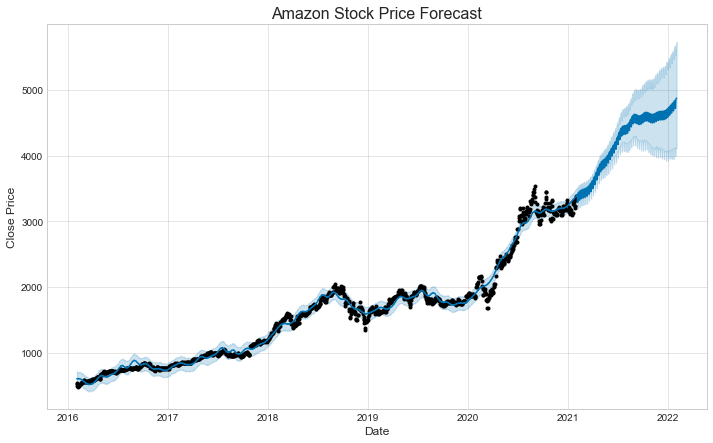

In [51]:
import matplotlib.dates as mdates

# Dates
starting_date = dt.datetime(2021, 2, 4)
starting_date1 = mdates.date2num(starting_date)
trend_date = dt.datetime(2021, 4, 4)
trend_date1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2021, 1, 4)
pointing_arrow1 = mdates.date2num(pointing_arrow)

# Learn more Prophet tomorrow and plot the forecast for amazon.
fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("Amazon Stock Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)

# # Forecast initialization arrow
# ax1.annotate('Forecast \n Initialization', xy=(pointing_arrow1, 1950), xytext=(starting_date1,1900),
#             arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
#             )

# # Trend emphasis arrow
# ax1.annotate('Upward Trend', xy=(trend_date1, 1225), xytext=(trend_date1,950),
#             arrowprops=dict(facecolor='#6cff6c', shrink=0.1),
#             )

# ax1.axhline(y=1260, color='b', linestyle='-')

plt.show()

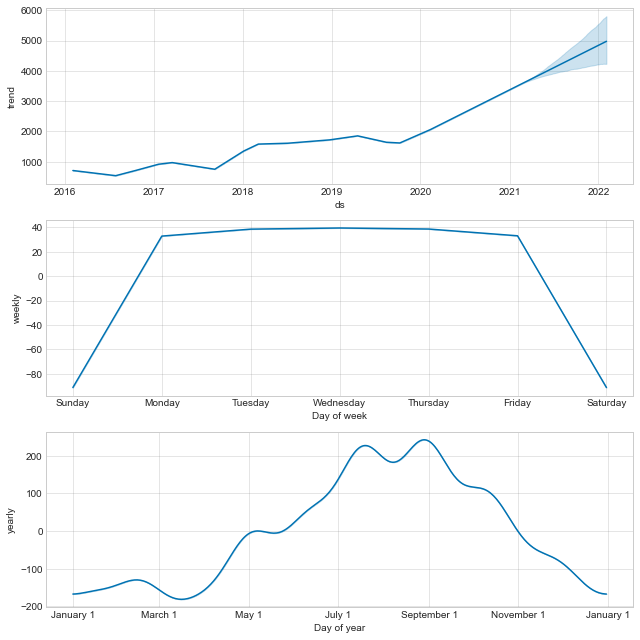

In [52]:
fig2 = m.plot_components(forecast)
plt.show()

# Dynamic Time Warping

In [153]:
df1 = pd.read_csv(path + 'CVX_data.csv')
series1 = df1[['Date', 'Close']].copy()
df2 = pd.read_csv(path + 'SLB_data.csv')
series2 = df2[['Date', 'Close']].copy()
# for i in range(1, 5):
#     series1.loc[i, 'Close'] = round(sum(list(series1.Close.iloc[0:i+1]))/len(list(series1.Close.iloc[0:i+1])))
# for i in range(5, len(series1)):
#     series1.loc[i, 'Close'] = round(sum(list(series1.Close.iloc[i-5:i+1]))/len(list(series1.Close.iloc[i-5:i+1])))

# for i in range(1, 5):
#     series2.loc[i, 'Close'] = round(sum(list(series2.Close.iloc[0:i+1]))/len(list(series2.Close.iloc[0:i+1])))
# for i in range(5, len(series1)):
#     series2.loc[i, 'Close'] = round(sum(list(series2.Close.iloc[i-5:i+1]))/len(list(series2.Close.iloc[i-5:i+1])))


x1 = series1['Close'].tolist()
x2 = series2['Close'].tolist()

In [154]:
dtw_distance, warp_path = fastdtw(x1, x2, dist=euclidean)

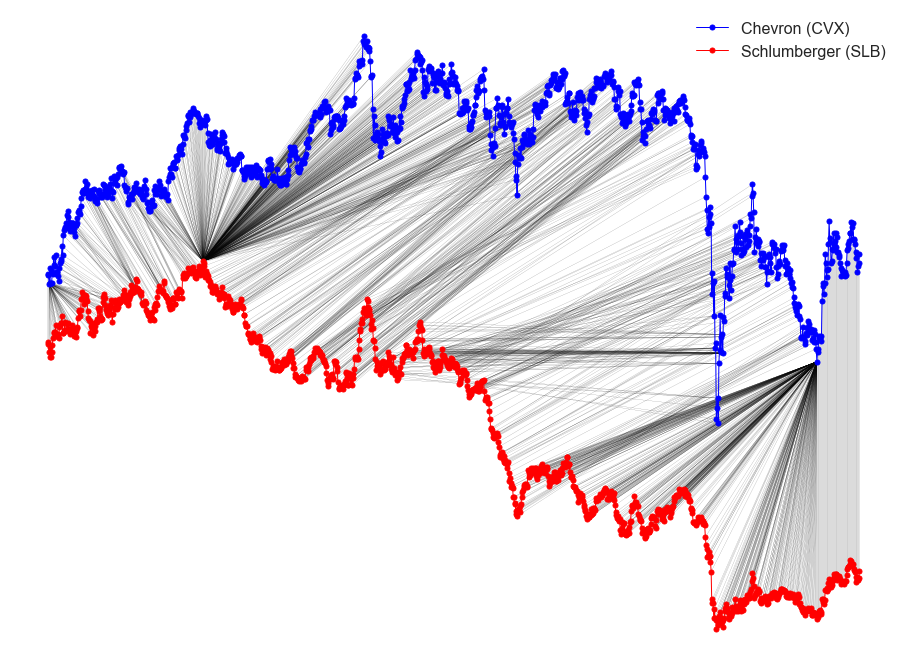

In [156]:
fig, ax = plt.subplots(figsize=(16, 12))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x1[map_x], x2[map_y]], '-k', linewidth=.1)

ax.plot(x1, color='blue', marker='o', markersize=5, linewidth=1, label='Chevron (CVX)')
ax.plot(x2, color='red', marker='o', markersize=5, linewidth=1, label='Schlumberger (SLB)')
ax.legend(fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=18)